In [1]:
import numpy as np
from matplotlib import pyplot as plt
import py_gauge_mc
import os
from tqdm.notebook import tqdm

In [2]:
def make_graph(l, inv_ks, vlen=64, lambdas=None):
    first_pots = np.asarray([
        inv_ks[0] * np.arange(vlen)**lam
        for lam in lambdas
    ])
    first_pots[first_pots>1000.0] = 1000.0
    
    pots = np.asarray([0.0, 1.0] + [10000.0]*(vlen-2))
    second_pots = np.einsum('i,j->ij', inv_ks, pots)
    
    vn = np.vstack([first_pots, second_pots])
    
    graph = py_gauge_mc.GPUGaugeTheory(l,l,l,l,vn.astype(np.float32))
    return graph, vn

In [3]:
L = 4
vlen = 128
n_lambdas = 128
n_invks = 128

pwr = 2.0
start = 2.0
end = 8.0
off = 1.0
lambdas = np.linspace((start - off)**(1.0/pwr),(end - off)**(1.0/pwr),n_lambdas)**pwr + off
inv_ks = np.linspace(0.1,1.0,n_invks)

graph,vn = make_graph(L,inv_ks,vlen=vlen,lambdas=lambdas)

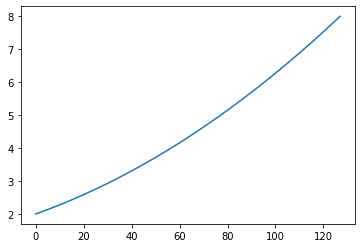

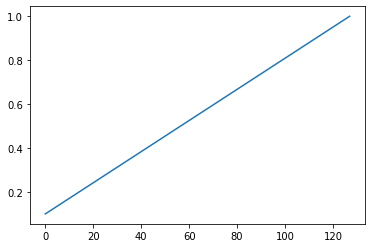

In [4]:
plt.plot(lambdas)
plt.show()
plt.plot(inv_ks)
plt.show()

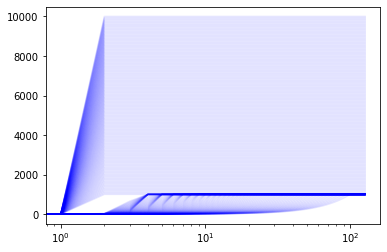

In [5]:
for pot in vn:
    plt.plot(pot, c='b', alpha=0.1)
plt.xscale('log')
plt.show()

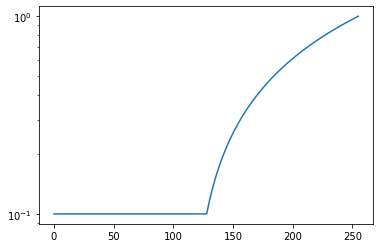

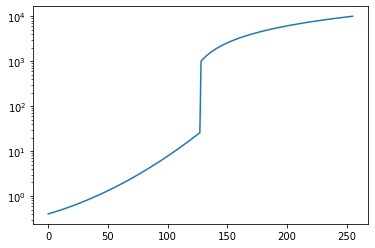

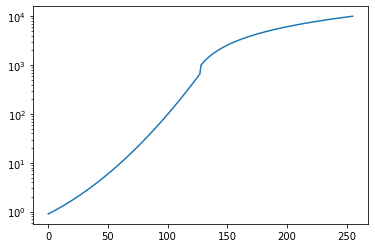

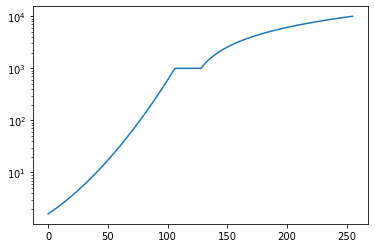

In [6]:
plt.plot(vn[:,1])
plt.yscale('log')
plt.show()

plt.plot(vn[:,2])
plt.yscale('log')
plt.show()

plt.plot(vn[:,3])
plt.yscale('log')
plt.show()

plt.plot(vn[:,4])
plt.yscale('log')
plt.show()

In [7]:
%%time

graph.simulate(10000,run_parallel_tempering=False,run_global_updates=False)

CPU times: user 2.36 s, sys: 19.6 ms, total: 2.38 s
Wall time: 2.37 s


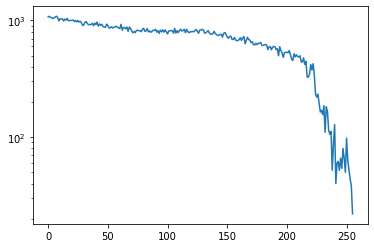

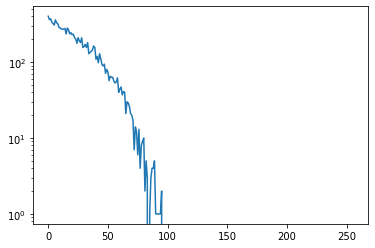

In [8]:
plt.plot((np.abs(graph.get_graph_state()) > 0).sum(axis=(-1,-2,-3,-4,-5)))
plt.yscale('log')
plt.show()

plt.plot((np.abs(graph.get_graph_state()) > 1).sum(axis=(-1,-2,-3,-4,-5)))
plt.yscale('log')
plt.show()

In [9]:
%%time

graph.simulate(10000,run_parallel_tempering=False)

CPU times: user 2.61 s, sys: 26.3 ms, total: 2.64 s
Wall time: 2.63 s


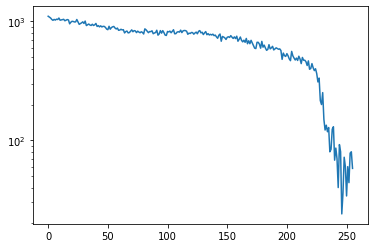

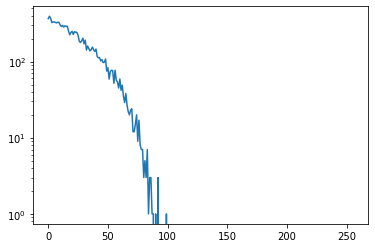

In [10]:
plt.plot((np.abs(graph.get_graph_state()) > 0).sum(axis=(-1,-2,-3,-4,-5)))
plt.yscale('log')
plt.show()

plt.plot((np.abs(graph.get_graph_state()) > 1).sum(axis=(-1,-2,-3,-4,-5)))
plt.yscale('log')
plt.show()

In [11]:
%%time

graph.simulate(10000,run_parallel_tempering=True)

CPU times: user 11.5 s, sys: 31.7 s, total: 43.2 s
Wall time: 45 s


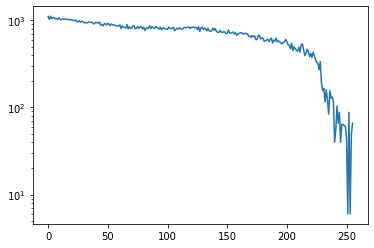

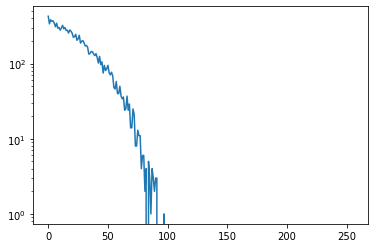

In [12]:
plt.plot((np.abs(graph.get_graph_state()) > 0).sum(axis=(-1,-2,-3,-4,-5)))
plt.yscale('log')
plt.show()

plt.plot((np.abs(graph.get_graph_state()) > 1).sum(axis=(-1,-2,-3,-4,-5)))
plt.yscale('log')
plt.show()

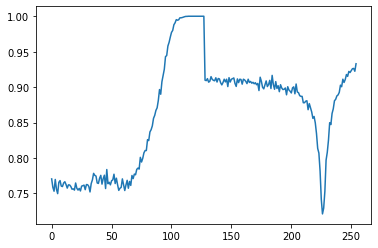

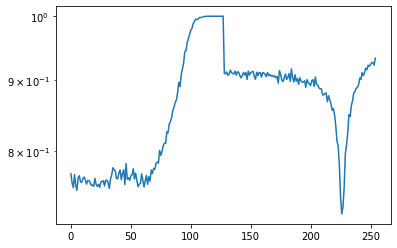

In [13]:
par_succ = graph.get_parallel_tempering_success_rate()

plt.plot(par_succ)
plt.show()

plt.plot(par_succ)
plt.yscale('log')
plt.show()

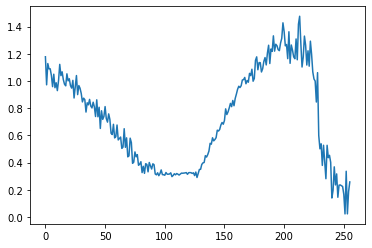

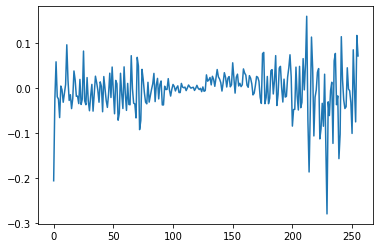

In [14]:
plt.plot(graph.get_energy() / (L**4))
plt.show()

plt.plot(np.gradient(graph.get_energy()) / (L**4))
plt.show()

In [15]:
%%time

# filename = "binary_tempering_winding_Var.npz"
# filename = "binary_tempering_winding_Var_new.npz"
# filename = f"binary_tempering_winding_var_L={L}.npz"

filename = f"faster_binary_tempering_winding_var_L={L}.npz"
if not os.path.exists(filename):
    var_wns = graph.simulate_and_get_winding_variance(10000,
                                                      local_updates_per_step=10,
                                                      steps_per_sample=10,
                                                      run_parallel_tempering=True)
    np.savez(filename, var_wns=var_wns, lambdas=lambdas, inv_ks=inv_ks, L=L)
else:
    arr = np.load(filename)
    var_wns = arr['var_wns']
    lambdas = arr['lambdas']
    inv_ks = arr['inv_ks']
    L = arr['L']

CPU times: user 1min 1s, sys: 56.7 s, total: 1min 58s
Wall time: 1min 11s


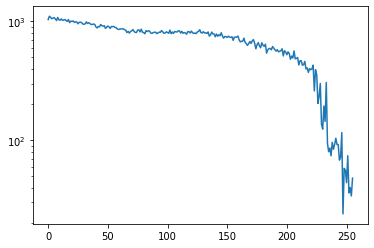

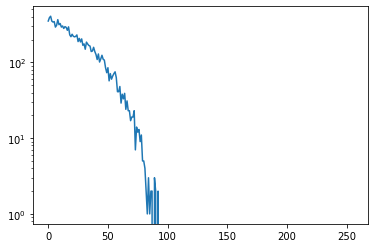

In [16]:
plt.plot((np.abs(graph.get_graph_state()) > 0).sum(axis=(-1,-2,-3,-4,-5)))
plt.yscale('log')
plt.show()

plt.plot((np.abs(graph.get_graph_state()) > 1).sum(axis=(-1,-2,-3,-4,-5)))
plt.yscale('log')
plt.show()

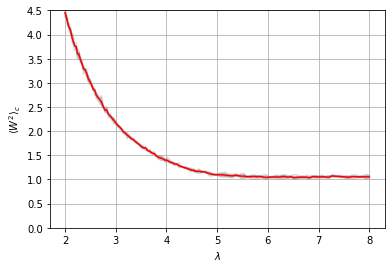

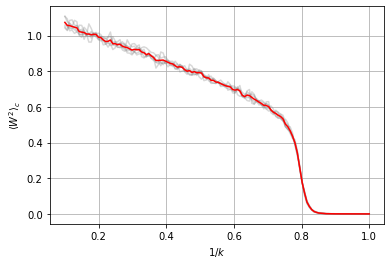

In [17]:
a_series = var_wns[:len(lambdas),...]
b_series = var_wns[len(lambdas):,...]

for i in range(6):
    plt.plot(lambdas, a_series[:,i], c='grey', alpha=0.3)
    
plt.plot(lambdas, a_series.mean(axis=-1), c='red')
plt.grid()
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\langle W^2 \rangle_c$')
plt.ylim([0,4.5])
plt.savefig('lambda_tempering_winding.pdf')
plt.show()

for i in range(6):
    plt.plot(inv_ks, b_series[:,i], c='grey', alpha=0.3)

plt.plot(inv_ks, b_series.mean(axis=-1), c='red')
plt.grid()
plt.xlabel(r'$1/k$')
plt.ylabel(r'$\langle W^2 \rangle_c$')
plt.savefig('binary_tempering_winding.pdf')
plt.show()

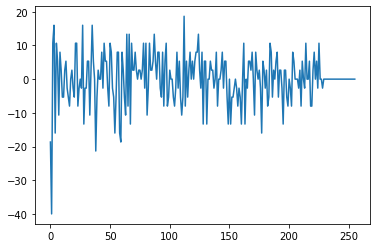

In [18]:
state = graph.get_graph_state()

plt.plot(state.sum(axis=(1,2,3,4)).mean(axis=-1))

# Run across sizes

In [30]:
output_dir = "binary_tempering"
os.makedirs(output_dir, exist_ok=True)
filename_format = os.path.join(output_dir, "data_binary_tempering_winding_var_L_{}.npz")

ls = [12,10,8,6,4]
vlen = 128
n_lambdas = 128
n_invks = 128

pwr = 2.0
start = 2.0
end = 8.0
off = 1.0
lambdas = np.linspace((start - off)**(1.0/pwr),(end - off)**(1.0/pwr),n_lambdas)**pwr + off
inv_ks = np.linspace(0.1,1.0,n_invks)

therm_no_global_steps = 10000
therm_global_steps = 10000
therm_tempering_steps = 10000

# Sampling
samples = 10000
local_updates_per_step = 10
steps_per_sample = 10

In [31]:
for l in tqdm(ls):
    filename = filename_format.format(l)
    
    if not os.path.exists(filename):
        graph,vn = make_graph(l,inv_ks,vlen=vlen,lambdas=lambdas)
        graph.simulate(therm_no_global_steps,
                       run_parallel_tempering=False,
                       run_global_updates=False)
        graph.simulate(therm_global_steps,
                       run_parallel_tempering=False,
                       run_global_updates=True)
        graph.simulate(therm_tempering_steps,
                       run_parallel_tempering=True,
                       run_global_updates=True)
        var_wns = graph.simulate_and_get_winding_variance(samples,
                                                          local_updates_per_step=local_updates_per_step,
                                                          steps_per_sample=steps_per_sample,
                                                          run_parallel_tempering=True)
        np.savez(filename, var_wns=var_wns, lambdas=lambdas, inv_ks=inv_ks, L=l)

  0%|          | 0/5 [00:00<?, ?it/s]

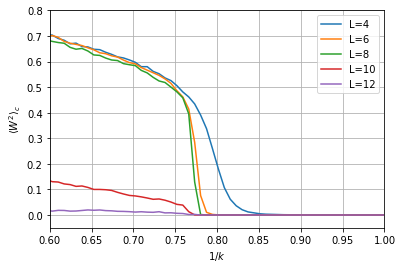

In [32]:
for l in reversed(ls):
    filename = filename_format.format(l)
    arr = np.load(filename)
    var_wns = arr['var_wns']
    lambdas = arr['lambdas']
    inv_ks = arr['inv_ks']
    L = arr['L']
    
    a_series = var_wns[:len(lambdas),...]
    b_series = var_wns[len(lambdas):,...]
    
    plt.plot(inv_ks, b_series.mean(axis=-1), label=f"L={L}")
    
plt.grid()
plt.xlabel(r'$1/k$')
plt.ylabel(r'$\langle W^2 \rangle_c$')
plt.legend()
plt.savefig('binary_tempering_winding.pdf')
plt.show()